#### Story Generator -> 
#####     Character Generator (Public for all prompts to the image generator) (Done)
#####      Story generation as Scenes with all characters (Done)
#####      Title of the Book Generator (done )
#####       Create a Graph workflow (done)
To Do:

create a reproducilble chain for creating a image of a scene
research for TTS models
os.env

problems:
character inconsistency
style of image changing
Not enough context to bring the whole picture into the book

In [52]:
import uuid

from typing import TypedDict,List , NotRequired
from langgraph.graph import END,StateGraph
from langchain_core.prompts import PromptTemplate
from storygenerator.schemas import Story,Scenes
from storygenerator.chains import scenesCreationChain,storyCreationChain,usersPromptGradingChain
from storygenerator.imagegenerator import generateImage

## State of the Graph
class BookState(TypedDict):
    users_prompt : str
    story: NotRequired[Story]
    scenes: NotRequired[Scenes]
    grade: NotRequired[str]
    users_id : NotRequired[int]

##templates
titleImageGenerationTemplate = PromptTemplate.from_template("""
    Create a Title page of the Book for this story book,
    - Anywhere in the image place this title : '{title}' **ALWAYS INCLUDE THIS TITLE IN THE IMAGE** 
    -Make Sure Texts you create in the image is accurate and not a gibberish so focus more on that
    -Dont Explicitly name things like 'Title of the book' near the title 
    - Only extract the theme from the below context
{character_description}\n\n{story}\n\

""") 

sceneImageGenerationTemplate = PromptTemplate.from_template("""

{current_scene}
                                                            
system_message: 
You are a creative AI director who is best at setting the scene from imagination to image.
create the scene mentioned , you will have a context of what happened before and what is the current scene
                                                            
These are the Characters in the Story:
{character_description}
                                                        

""")

## Nodes
def usersPrompt(state:BookState) -> BookState:
    print("Accessing User's prompt...")
    grade = usersPromptGradingChain.invoke({"users_prompt":state["users_prompt"]})
    state["grade"] = grade.isStory.strip().lower()
    return state

def gradeThePrompt(state):
    print("Analysing the User's Prompt...")
    if (state["grade"]=="no"):
        print("Ending the Graph... , User's request is Not Valid")
        return END
    else:
        return "storycreator"
    
def storyCreator(state:BookState) -> BookState:
    print("Entering Story Creation Node...")
    story = storyCreationChain.invoke({"users_prompt":state["users_prompt"]})
    print("Story Created...")
    state["story"] = story
    state["users_id"] = uuid.uuid4()
    return state

def titleImageCreator(state:BookState) -> BookState:
    print("Entering Title Image Creation Node...")
    story = state["story"]
    prompt = titleImageGenerationTemplate.format(**{"character_description":story.characterDescription,"story":story.story,"title":story.title})
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="title.png")
    print("Created a Title Image....")
    return {}

def scenesCreator(state:BookState) -> BookState:
    print("Entering Scenes Creation Node... ")
    story = state["story"]
    scenes = scenesCreationChain.invoke({"story":story.story,"character_description":story.characterDescription,"title":story.title})
    print("Created Scenes")
    state["scenes"] = scenes
    print(scenes)
    return state

def scene1ImageCreator(state:BookState) -> BookState:
    print("Entering Scene 1 Image Creation Node...")
    story = state["story"]
    previous_scenes = "NO PREVIOUS SCENES"
    current_scene = state["scenes"].scenes[0]
    kwargs = {"character_description":story.characterDescription,"story":story.story,"title":story.title, "previous_scenes":previous_scenes,"current_scene":current_scene}
    prompt = sceneImageGenerationTemplate.format(**kwargs)
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="scene1.png")
    print("created scene 1 image")
    return {}

def scene2ImageCreator(state:BookState) -> BookState:
    print("Entering Scene 2 Image Creation Node...")
    story = state["story"]
    previous_scenes = "\n\n".join([f"scene_{i}\n"+scene for i,scene in enumerate(state["scenes"].scenes) if i < 1])
    current_scene = state["scenes"].scenes[1]
    kwargs = {"character_description":story.characterDescription,"story":story.story,"title":story.title, "previous_scenes":previous_scenes,"current_scene":current_scene}
    prompt = sceneImageGenerationTemplate.format(**kwargs)
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="scene2.png")
    print("created scene 2 image")
    return {}

def scene3ImageCreator(state:BookState) -> BookState:
    print("Entering Scene 3 Image Creation Node...")
    story = state["story"]
    previous_scenes = "\n\n".join([f"scene_{i}\n"+scene for i,scene in enumerate(state["scenes"].scenes) if i < 2])
    current_scene = state["scenes"].scenes[2]
    kwargs = {"character_description":story.characterDescription,"story":story.story,"title":story.title, "previous_scenes":previous_scenes,"current_scene":current_scene}
    prompt = sceneImageGenerationTemplate.format(**kwargs)
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="scene3.png")
    print("created scene 3 image")
    return {}

def scene4ImageCreator(state:BookState) -> BookState:
    print("Entering Scene 4 Image Creation Node...")
    story = state["story"]
    previous_scenes = "\n\n".join([f"scene_{i}\n"+scene for i,scene in enumerate(state["scenes"].scenes) if i < 3])
    current_scene = state["scenes"].scenes[3]
    kwargs = {"character_description":story.characterDescription,"story":story.story,"title":story.title, "previous_scenes":previous_scenes,"current_scene":current_scene}
    prompt = sceneImageGenerationTemplate.format(**kwargs)
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="scene4.png")
    print("created scene 4 image")
    return {}

def scene5ImageCreator(state:BookState) -> BookState:
    print("Entering Scene 5 Image Creation Node...")
    story = state["story"]
    previous_scenes = "\n\n".join([f"scene_{i}\n"+scene for i,scene in enumerate(state["scenes"].scenes) if i < 4])
    current_scene = state["scenes"].scenes[4]
    kwargs = {"character_description":story.characterDescription,"story":story.story,"title":story.title, "previous_scenes":previous_scenes,"current_scene":current_scene}
    prompt = sceneImageGenerationTemplate.format(**kwargs)
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="scene5.png")
    print("created scene 5 image")
    return {}

graph = StateGraph(BookState)

graph.add_node("usersprompt",usersPrompt)
graph.add_node("storycreator",storyCreator)
graph.add_node("titleimagecreator",titleImageCreator)
graph.add_node("scenescreator",scenesCreator)
graph.add_node("scene1imagecreator",scene1ImageCreator)
graph.add_node("scene2imagecreator",scene2ImageCreator)
graph.add_node("scene3imagecreator",scene3ImageCreator)
graph.add_node("scene4imagecreator",scene4ImageCreator)
graph.add_node("scene5imagecreator",scene5ImageCreator)


graph.set_entry_point("usersprompt")
graph.add_conditional_edges("usersprompt",gradeThePrompt,[END,"storycreator"])
graph.add_edge("storycreator","titleimagecreator")
graph.add_edge("titleimagecreator",END)
graph.add_edge("storycreator","scenescreator")
graph.add_edge("scenescreator","scene1imagecreator")
graph.add_edge("scene1imagecreator","scene2imagecreator")
graph.add_edge("scene2imagecreator","scene3imagecreator")
graph.add_edge("scene3imagecreator","scene4imagecreator")
graph.add_edge("scene4imagecreator","scene5imagecreator")
graph.add_edge("scene5imagecreator",END)

app = graph.compile()



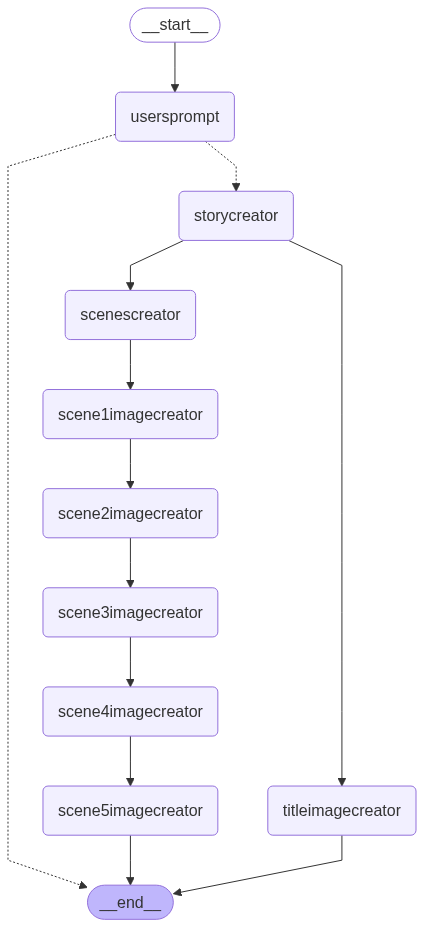

In [53]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [54]:
book = app.invoke({"users_prompt":"Create a Story Depicting FriendShip , Love and Hatred "})

Accessing User's prompt...
Analysing the User's Prompt...
Entering Story Creation Node...
Story Created...
Entering Scenes Creation Node... 
Entering Title Image Creation Node...

    Create a Title page of the Book for this story book,
    - Anywhere in the image place this title : 'The Web of Emotions' **ALWAYS INCLUDE THIS TITLE IN THE IMAGE** 
    -Make Sure Texts you create in the image is accurate and not a gibberish so focus more on that
    -Dont Explicitly name things like 'Title of the book' near the title 
    - Only extract the theme from the below context
 Character 1: Alex - A 25-year-old tall, dark-haired, and blue-eyed young man with a strong build and a charming smile. He is kind, loyal, and always ready to help others. He loves to wear casual clothes and has a passion for music. 
 Character 2: Emma - A 23-year-old beautiful, blonde-haired, and green-eyed young woman with a petite build and a sweet smile. She is gentle, caring, and always looks out for others. She love

In [55]:
book["story"].story


"Title: The Web of Emotions \n Alex and Emma had been the best of friends since college. They shared everything with each other, from their deepest secrets to their wildest dreams. Their friendship was pure and strong, and everyone in town looked up to them as a perfect example of true friendship. One day, Ryan, a wealthy businessman, entered their lives. He was charming and charismatic, and Emma was immediately drawn to him. Alex, however, was wary of Ryan's intentions and warned Emma to be cautious. But Emma was smitten, and soon, she and Ryan started dating. As time passed, Alex noticed that Emma was changing. She was no longer the kind and caring person he once knew. Ryan's influence had turned her into a selfish and arrogant person. Alex tried to talk to her, but she wouldn't listen. The friendship that once meant the world to her was now nothing but a distant memory. Alex was heartbroken. He felt betrayed and abandoned by his best friend. He started to distance himself from Emma,

In [56]:
for i,scene in enumerate(book["scenes"].scenes):
    print(i,scene)

0 Scene 1: Alex and Emma walking together on a sunny day, laughing and chatting, with a bright blue sky in the background.
1 Scene 2: Ryan, dressed in a formal suit, standing in front of a luxurious car, with a sly smile on his face.
2 Scene 3: Emma, wearing a bright yellow dress, sitting on a couch, looking confused and torn, with Ryan's influence evident on her face.
3 Scene 4: Alex, sitting alone on a bench, looking sad and heartbroken, with a guitar lying next to him.
4 Scene 5: Alex and Emma standing together, holding hands, with a warm sunset in the background, symbolizing their rekindled friendship.


In [57]:
for i,scene in enumerate(book["scenes"].voiceovers):
    print(i,scene)

0 The bond between Alex and Emma was unbreakable, or so it seemed.
1 Ryan's charm and charisma hid a sinister intent, one that would change the course of their lives forever.
2 As Emma fell deeper under Ryan's spell, Alex's warnings fell on deaf ears.
3 The pain of betrayal and heartbreak drove Alex away from the one person he trusted most.
4 In the end, love and forgiveness prevailed, and the web of emotions that once entangled them was broken.


In [15]:
print(book["story"].characterDescription)

Character 1: Rohan - 12 years old, short and lean, with curly brown hair and bright green eyes. He is a happy-go-lucky boy who loves playing pranks on his friends. Character 2: Aryan - 12 years old, tall and athletic, with short black hair and piercing blue eyes. He is a clever and resourceful boy who is always there to help his friends. Ghoul: Kali - a dark and sinister entity with long, bony fingers and glowing red eyes. It has the ability to disguise itself as anyone it desires.


In [16]:
book["story"].story

"Rohan and Aryan were the best of friends since kindergarten. They did everything together, from playing soccer to exploring the woods behind their school. One day, Aryan fell ill and passed away, leaving Rohan devastated. But what Rohan didn't know was that a ghoul named Kali had been watching them from the shadows. Kali, drawn to the strong bond between the two friends, decided to disguise itself as Aryan to deceive Rohan. At first, Rohan was overjoyed to have his friend back, but he soon began to notice strange occurrences. Aryan would often disappear during the night, and when Rohan would ask him where he went, Aryan would change the subject. Rohan's instincts told him something was off, but he couldn't shake off the feeling that his friend was back. One night, Rohan decided to follow Aryan and discovered the shocking truth. Kali, in its true form, was lurking in the shadows, waiting for the perfect moment to strike. Rohan was horrified, but he didn't want to give up on his friend.

In [47]:
from together import Together

client = Together()
response = client.images.generate(
    prompt="Cats eating popcorn",
    model="black-forest-labs/FLUX.1-schnell-free",
    steps=4,
    n=4,
    width=352,   # multiple of 16
    height=256,
    response_format="b64_json"
)
print(response.data[0].b64_json)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAWADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDy8DFOxSCnCtDjAU7FIKdQACnYpBThQIAKdigUtAgFLiilFMQopaSlFACilopRQIWiiloAAKWiigQYpaKWgBMUtLRQISilooATFFLRQAlJS0lAxKSnUlACU2nUlAxtIadSUANNIacaQ0DGUlONJQMbimmnGkNIBtNNOpKBjTTS

In [48]:
import base64
from PIL import Image
from io import BytesIO
# Decode the base64 string to bytes
image_bytes = base64.b64decode(response.data[0].b64_json)

# Open the image using PIL
image = Image.open(BytesIO(image_bytes))

# Optional: Save the image locally
image.save("output_image.png")

# Optional: Show the image
image.show()
